<a href="https://colab.research.google.com/github/Wallbreaker100/miniProject/blob/master/temp_mini_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from scipy.interpolate import RectBivariateSpline
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale, rotate
from google.colab import drive
from google.colab import files
import cv2
uploaded = files.upload()
#drive.mount('/content/drive')

Saving images.png to images.png


In [38]:
image_path = list(uploaded.keys())[0]
image = Image.open(image_path)
image.show()
gray_image=cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
# image = np.array(image)
# gray_image = np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])
image=gray_image

In [39]:
image=cv2.equalizeHist(image)

In [ ]:
#image = shepp_logan_phantom()
#image = np.ones([100,100])
# Resize Image
diag = len(np.diag(gray_image)//2)
image = np.pad(gray_image, pad_width=diag-160)
image

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
image.shape[1]
# gray_image

430

In [ ]:
_ = np.linspace(-1, 1, image.shape[0])
xv, yv = np.meshgrid(_,_)
#image[(xv-0.1)**2+(yv-0.2)**2<0.01] = 2

# Create a rotated image
image_rot = rotate(image, 45)

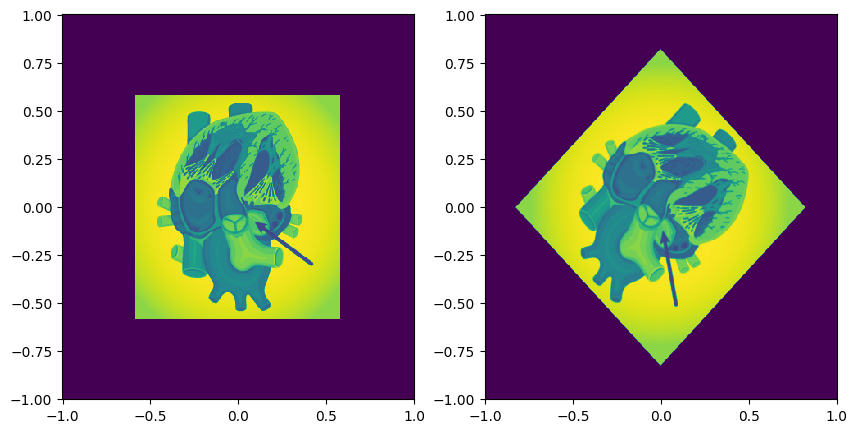

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].pcolor(xv,yv,image)
ax[1].pcolor(xv,yv,image_rot)
plt.show()

In [ ]:
thetas = np.arange(0,180,5) * np.pi/180
rs = _
dtheta = np.diff(thetas)[0]
dr = np.diff(rs)[0]
rotations = np.array([rotate(image, theta*180/np.pi) for theta in thetas])

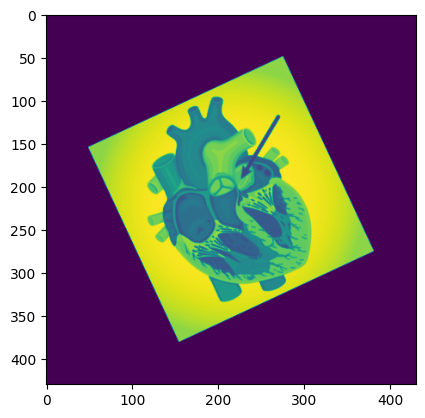

In [ ]:
plt.imshow(rotations[5])

In [ ]:
p = np.array([rotation.sum(axis=0)*dr for rotation in rotations]).T

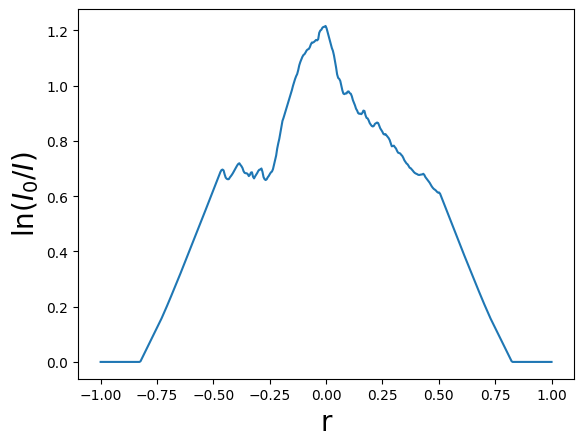

In [ ]:
plt.plot(rs, p[:,9])
plt.xlabel('r', fontsize=20)
plt.ylabel('$\ln(I_0/I)$', fontsize=20)
plt.show()

In [ ]:
p.shape[0]

430

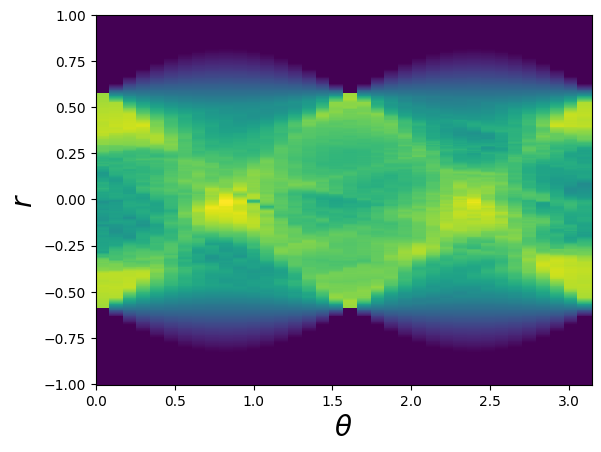

In [ ]:
Thetas, Rs = np.meshgrid(thetas, rs)
thetas_extended = np.append(thetas, thetas[-1] + (thetas[-1] - thetas[-2]))

# For rs, add an extra value at the beginning
rs_extended = np.insert(rs, 0, rs[0] - (rs[1] - rs[0]))
p_transposed = np.transpose(p)
plt.pcolor(thetas_extended, rs_extended, p, shading='flat')
plt.xlabel(r'$\theta$', fontsize=20)
plt.ylabel('$r$', fontsize=20)
plt.show()

In [ ]:
p_interp = RectBivariateSpline(rs, thetas, p)

In [ ]:
def get_fBP(x,y):
    return p_interp(x*np.cos(thetas)+y*np.sin(thetas), thetas, grid=False).sum() * dtheta

fBP = np.vectorize(get_fBP)(xv,yv)

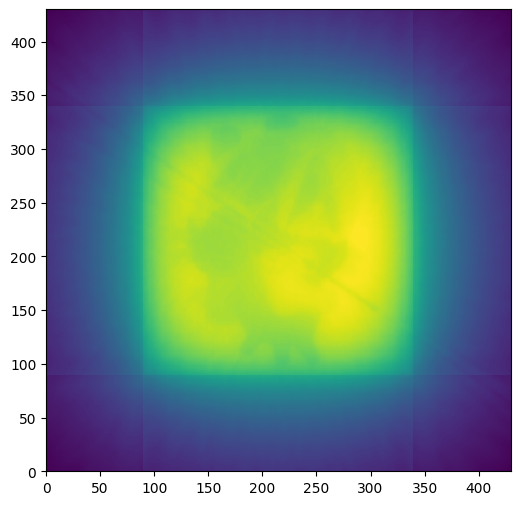

In [ ]:
plt.figure(figsize=(6,6))
plt.pcolor(fBP)
plt.show()

In [ ]:
from scipy.fft import fft, ifft

In [ ]:
P = fft(p, axis=0)
nu = np.fft.fftfreq(P.shape[0], d=np.diff(rs)[0])

In [ ]:
P.T.shape

(36, 430)

In [ ]:
nu.shape


(430,)

In [ ]:
integrand = P.T * np.abs(nu)
integrand = integrand.T
p_p = np.real(ifft(integrand, axis=0))

In [ ]:
p_p_interp = RectBivariateSpline(rs, thetas, p_p)

In [ ]:
def get_f(x,y):
    return p_p_interp(x*np.cos(thetas)+y*np.sin(thetas), thetas, grid=False).sum() * dtheta

f = np.vectorize(get_f)(xv,yv)

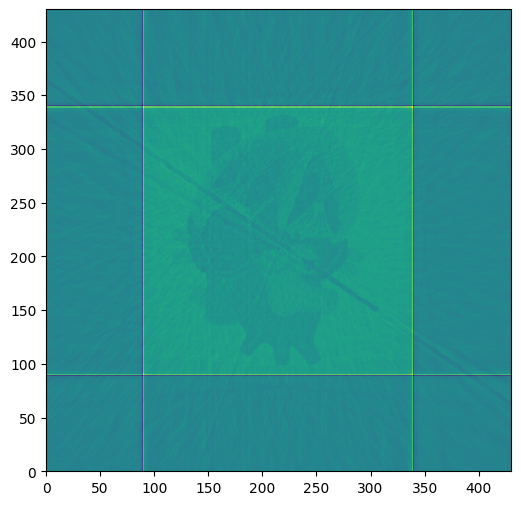

In [ ]:
plt.figure(figsize=(6,6))
plt.pcolor(f)
plt.show()

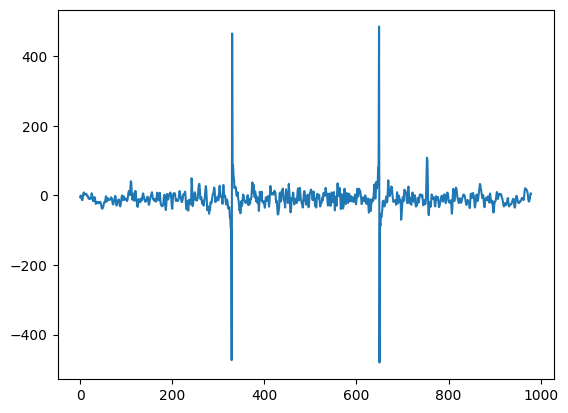

In [ ]:
plt.plot(f[110])

In [40]:
from skimage.transform import radon, iradon

In [103]:
theta = np.arange(0., 180., 10)
sinogram = radon(image, theta=theta)
sinogram

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Text(0, 0.5, 'degree')

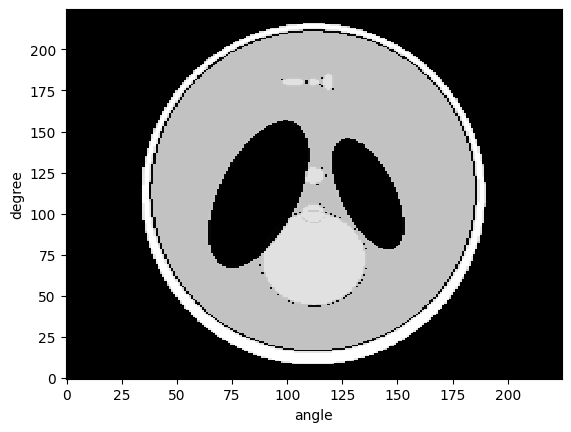

In [104]:
X, Y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))

# Plot the pseudocolor plot with gray colormap
plt.pcolor(X, Y, image, cmap='gray', shading='auto')

# plt.pcolor(sinogram)
# plt.imshow(sinogram,cmap='gray')
plt.xlabel("angle")
plt.ylabel("degree")

In [105]:
reconstruction_img = iradon(sinogram, theta=theta, filter_name='ramp')

In [84]:
# reconstruction_img=reconstruction_img.astype(np.uint8)

In [65]:
# reconstruction_img_uint8 =cv2.equalizeHist(reconstruction_img_uint8 )

error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/histogram.cpp:3440: error: (-215:Assertion failed) _src.type() == CV_8UC1 in function 'equalizeHist'


In [111]:
# reconstruction_img=cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
# Apply median filtering
median_filtered_image = cv2.medianBlur(reconstruction_img.astype(np.uint8), 5)  # Adjust the kernel size (5 in this example)

# Apply Gaussian blurring
gaussian_blurred_image = cv2.GaussianBlur(reconstruction_img.astype(np.uint8), (5, 5), 0)  # Adjust the kernel size (5, 5) and standard deviation (0) as needed

# Apply bilateral filtering
bilateral_filtered_image = cv2.bilateralFilter(reconstruction_img.astype(np.uint8), 9, 75, 75)  # Adjust the parameters (9, 75, 75) as needed

# Apply total variation denoising (using the TVDenoise package)
from skimage.restoration import denoise_tv_chambolle
total_variation_denoised_image  = denoise_tv_chambolle(reconstruction_img, weight=0.3)  # Adjust the weight parameter as needed

In [ ]:
# equalized_img=cv2.equalizeHist(reconstruction_img)

error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/histogram.cpp:3440: error: (-215:Assertion failed) _src.type() == CV_8UC1 in function 'equalizeHist'


<Figure size 1000x1000 with 0 Axes>

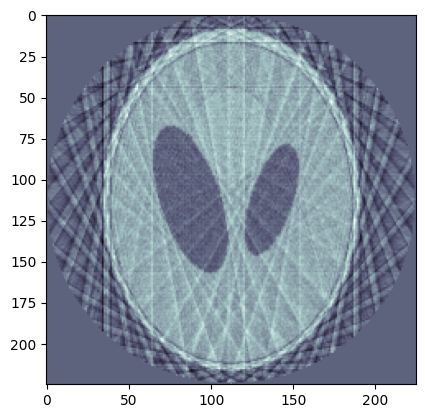

<Figure size 1000x1000 with 0 Axes>

In [112]:
from matplotlib.colors import LinearSegmentedColormap
# X, Y = np.meshgrid(np.arange(reconstruction_img.shape[1]), np.arange(reconstruction_img.shape[0]))
plt.figure(facecolor='white')
# cmap_white = LinearSegmentedColormap.from_list('white', [(0, 'white'), (1, 'white')])
plt.imshow(reconstruction_img, cmap="bone")
# Plot the pseudocolor plot with gray colormap
# plt.pcolor(X, Y, reconstruction_img, cmap='gray', shading='auto')

plt.figure(figsize=(10,10))
# plt.pcolor(reconstruction_img)

<Figure size 1000x1000 with 0 Axes>

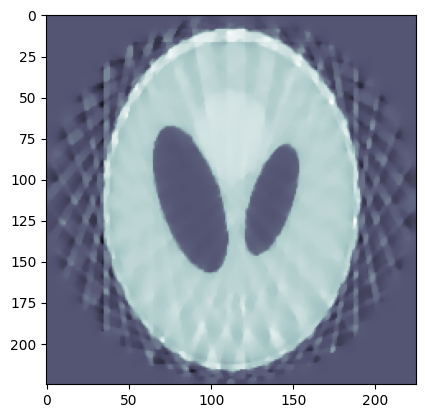

<Figure size 1000x1000 with 0 Axes>

In [113]:
from matplotlib.colors import LinearSegmentedColormap
# X, Y = np.meshgrid(np.arange(reconstruction_img.shape[1]), np.arange(reconstruction_img.shape[0]))
plt.figure(facecolor='white')
# cmap_white = LinearSegmentedColormap.from_list('white', [(0, 'white'), (1, 'white')])
plt.imshow(total_variation_denoised_image, cmap="bone")
# Plot the pseudocolor plot with gray colormap
# plt.pcolor(X, Y, reconstruction_img, cmap='gray', shading='auto')

plt.figure(figsize=(10,10))

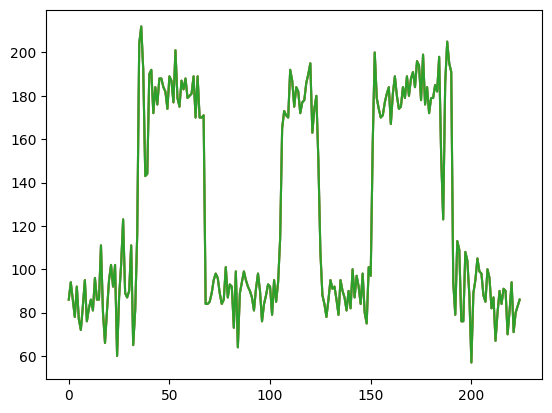

In [75]:
plt.plot(reconstruction_img[110])


In [15]:
# filtered_image=cv2.medianBlur(reconstruction_img,5)

error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/median_blur.simd.hpp:870: error: (-210:Unsupported format or combination of formats)  in function 'medianBlur'


In [13]:
from matplotlib.colors import LinearSegmentedColormap
# X, Y = np.meshgrid(np.arange(reconstruction_img.shape[1]), np.arange(reconstruction_img.shape[0]))
plt.figure(facecolor='white')
# cmap_white = LinearSegmentedColormap.from_list('white', [(0, 'white'), (1, 'white')])
plt.imshow(filtered_image, cmap="bone")
# Plot the pseudocolor plot with gray colormap
# plt.pcolor(X, Y, reconstruction_img, cmap='gray', shading='auto')

plt.figure(figsize=(10,10))

NameError: name 'filtered_image' is not defined

<Figure size 640x480 with 0 Axes>

In [20]:
print(image.shape)
reconstruction_img.shape

(512, 512)


(512, 512)

In [110]:
error = np.sqrt(np.mean((image.astype(float) - reconstruction_img)**2))
error

130.69460380133106

In [ ]:
error = np.sqrt(np.mean((image.astype(float) - reconstruction_img)**2))
error

In [ ]:
reconstruction_img

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])